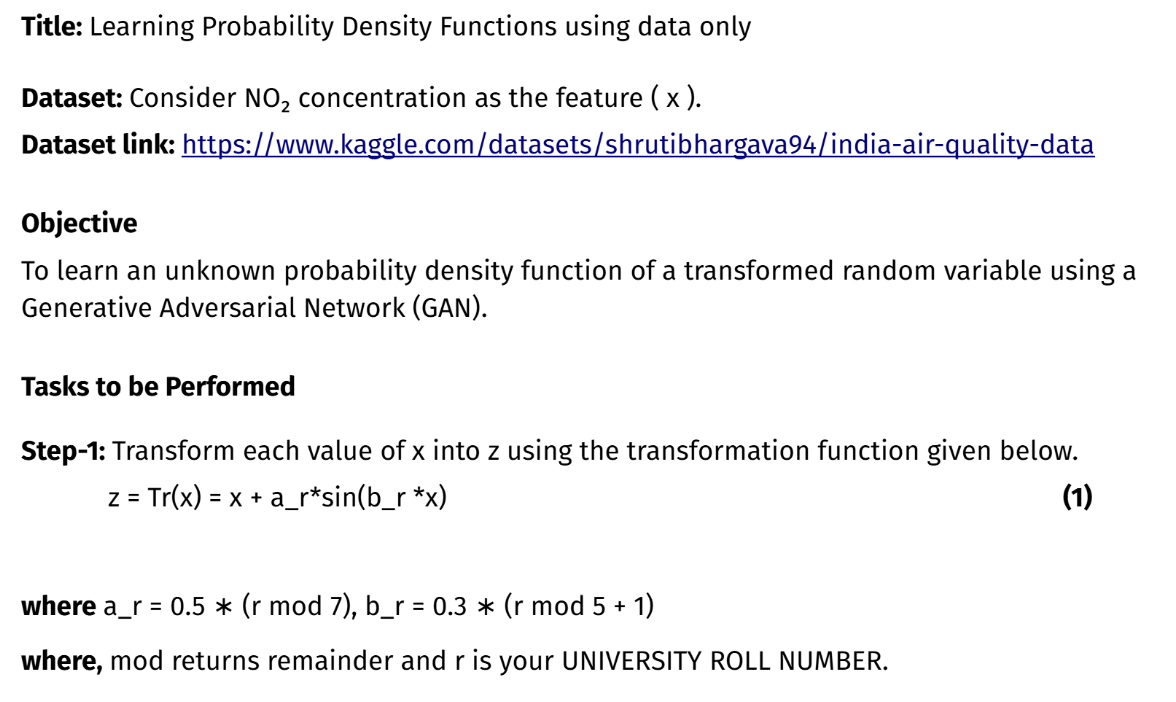

In [41]:
#Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import tensorflow as tf
from tensorflow.keras import layers, models

In [42]:
#Load Dataset
df = pd.read_csv("/content/data.csv", encoding="latin1")
df.head()

/tmp/ipython-input-1731864997.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/data.csv", encoding="latin1")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [43]:
#Extract NO2 Feature
x = df["no2"].dropna().values

x = (x - np.mean(x)) / np.std(x)
print("Number of samples:", len(x))

Number of samples: 419509


In [44]:
#Assigning Roll No to r
r = 102497014
#Parameters
ar = 0.05 * (r % 7)
br = 0.3 * ((r % 5) + 1)
print(ar)
print(br)

0.2
1.5


In [45]:
#Applying Transformation
z = x + ar * np.sin(br * x)
print(z)

[-0.58052924 -1.21635694  0.18867721 ...  1.23712316  1.49233338
  1.29075568]


In [46]:
#Reshape for Training
z = z.reshape(-1, 1)

In [48]:
#Converting to tensor
import torch
import torch.nn as nn
z_tensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)

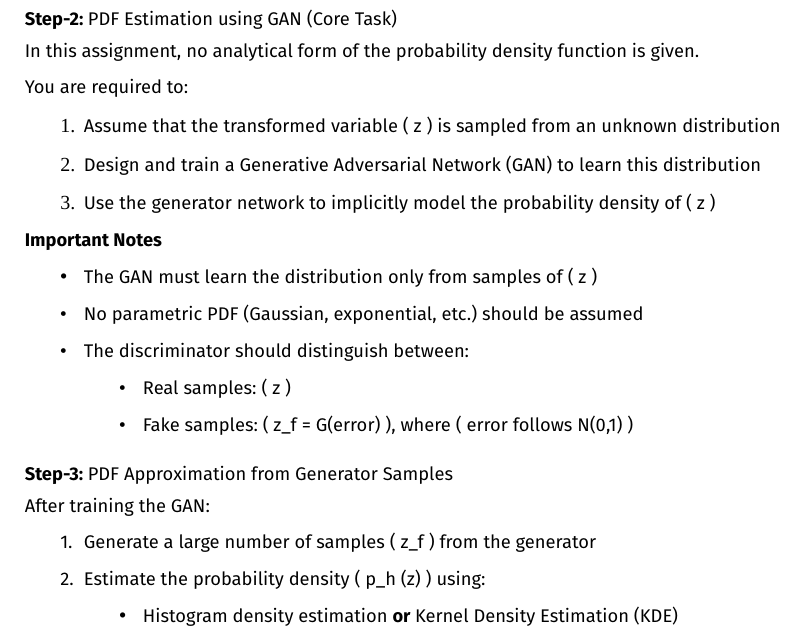

In [49]:
#GAN Architecture

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [50]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [51]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001)

In [52]:
#Train GAN
epochs = 3000
batch_size = 120

for epoch in range(epochs):
    idx = torch.randint(0, len(z_tensor), (batch_size,))
    real_z = z_tensor[idx]

    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    d_loss = (
        criterion(D(real_z), real_labels) +
        criterion(D(fake_z.detach()), fake_labels)
    )

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    noise = torch.randn(batch_size, 1)
    fake_z = G(noise)
    g_loss = criterion(D(fake_z), real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 0 | D Loss: 1.3736 | G Loss: 0.7028
Epoch 500 | D Loss: 1.3509 | G Loss: 0.7024
Epoch 1000 | D Loss: 1.3875 | G Loss: 0.6757
Epoch 1500 | D Loss: 1.3889 | G Loss: 0.6990
Epoch 2000 | D Loss: 1.3536 | G Loss: 0.7125
Epoch 2500 | D Loss: 1.3933 | G Loss: 0.6890


In [53]:
#Generate Samples from Generator
with torch.no_grad():
    noise = torch.randn(10000, 1)
    z_fake = G(noise).numpy()

In [54]:
#Estimate PDF using KDE
from scipy.stats import gaussian_kde
# KDE for real data
kde_real = gaussian_kde(z.flatten())

# KDE for GAN generated data
kde_fake = gaussian_kde(z_fake.flatten())

# Common plotting range
z_min_plot = min(z.min(), z_fake.min())
z_max_plot = max(z.max(), z_fake.max())

z_range = np.linspace(z_min_plot, z_max_plot, 500)

pdf_real = kde_real(z_range)
pdf_fake = kde_fake(z_range)

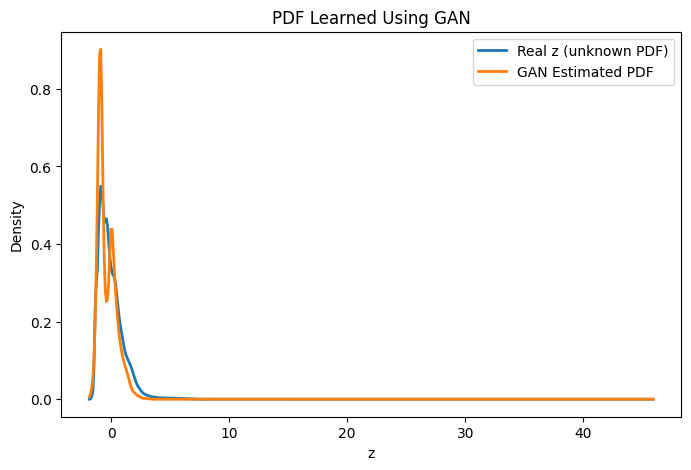

In [55]:
#Plot Real vs GAN Estimated PDF
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(z_range, pdf_real, label="Real z (unknown PDF)", linewidth=2)
plt.plot(z_range, pdf_fake, label="GAN Estimated PDF", linewidth=2)

plt.title("PDF Learned Using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()

**Observations:**


*   The GAN genrated PDF closely follows the real distribution.
*   Traning appears stable with no signs of model collapse.


*   Minor difference exists in peak region.
*   Overall, GAN provides a close approximation of the unknown PDF.





